In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load datasets
demographic_df = pd.read_csv("age_salary.csv")
behavioral_df = pd.read_csv("age_buynotbuy.csv")
vehicle_df = pd.read_csv("speedefficiencyPrice.csv")


In [2]:
# 2. data understandingabs
# Summary
print(demographic_df.info())
print(behavioral_df.info())
print(vehicle_df.info())

# Sample
print(demographic_df.head())
print(behavioral_df.head())
print(vehicle_df.head())

# Check for missing values
print(demographic_df.isnull().sum())
print(behavioral_df.isnull().sum())
print(vehicle_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               99 non-null     int64 
 1   Profession        99 non-null     object
 2   Marrital Status   99 non-null     object
 3   Education         99 non-null     object
 4   No of Dependents  99 non-null     int64 
 5   Personal loan     99 non-null     object
 6   Total Salary      99 non-null     int64 
 7   Price             99 non-null     int64 
dtypes: int64(4), object(4)
memory usage: 6.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 no

In [9]:
# 3.Demographic Dataset
demographic_clean = demographic_df.copy()
le = LabelEncoder()
for col in ['Profession', 'Marrital Status', 'Education', 'Personal loan']:
    demographic_clean[col] = le.fit_transform(demographic_clean[col])

scaler = StandardScaler()
demo_features = demographic_clean.drop(['Total Salary', 'Price'], axis=1)
scaled_demo = scaler.fit_transform(demo_features)


In [14]:
behavioral_clean = behavioral_df.copy()
behavioral_clean['Gender'] = le.fit_transform(behavioral_clean['Gender'])

scaled_behavioral = scaler.fit_transform(behavioral_clean[['Age', 'AnnualSalary']])


In [15]:
vehicle_clean = vehicle_df.copy()
vehicle_clean = vehicle_clean.select_dtypes(include=[np.number])
scaled_vehicle = scaler.fit_transform(vehicle_clean)


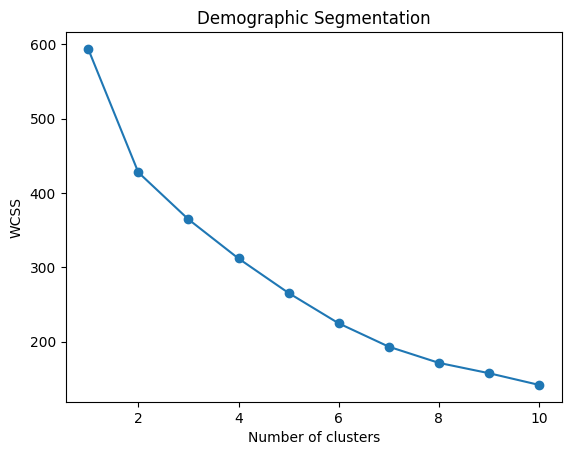

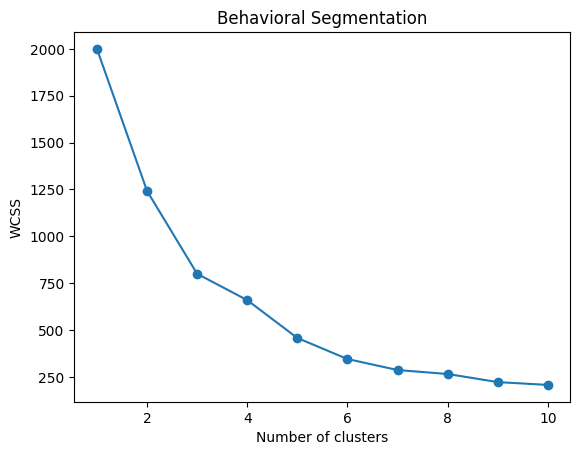

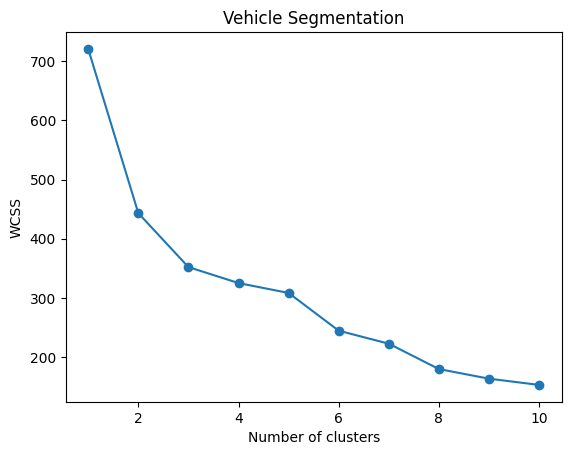

In [16]:
def plot_elbow(data, title='Elbow Method'):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
plot_elbow(scaled_demo, 'Demographic Segmentation')
plot_elbow(scaled_behavioral, 'Behavioral Segmentation')
plot_elbow(scaled_vehicle, 'Vehicle Segmentation')


In [17]:
# Choose number of clusters based on elbow method
k_demo = 2
k_behavioral = 3
k_vehicle = 6

# Demographic clustering
kmeans_demo = KMeans(n_clusters=k_demo, random_state=0)
demographic_clean['Cluster'] = kmeans_demo.fit_predict(scaled_demo)

# Behavioral clustering
kmeans_behavior = KMeans(n_clusters=k_behavioral, random_state=0)
behavioral_clean['Cluster'] = kmeans_behavior.fit_predict(scaled_behavioral)

# Vehicle clustering
kmeans_vehicle = KMeans(n_clusters=k_vehicle, random_state=0)
vehicle_df['Cluster'] = kmeans_vehicle.fit_predict(scaled_vehicle)


In [18]:
# Profile Demographic Segments
print(demographic_clean.groupby('Cluster').mean())

# Profile Behavioral Segments
print(behavioral_clean.groupby('Cluster').mean())

# Profile Vehicle Segments
print(vehicle_df.groupby('Cluster').mean())


               Age  Profession  Marrital Status  Education  No of Dependents  \
Cluster                                                                        
0        37.761905    0.654762              0.0   0.559524          2.523810   
1        28.200000    0.600000              1.0   0.600000          0.266667   

         Personal loan  Total Salary         Price  
Cluster                                             
0             0.321429  2.454762e+06  1.221548e+06  
1             0.333333  1.240000e+06  1.040000e+06  
            User ID    Gender        Age   AnnualSalary  Purchased
Cluster                                                           
0        514.181176  0.512941  46.374118   58088.235294   0.456471
1        488.504386  0.372807  45.197368  123212.719298   0.872807
2        491.625360  0.521614  29.083573   57374.639769   0.025937


TypeError: agg function failed [how->mean,dtype->object]

In [19]:
# Merge behavioral with demographic based on Age (if ages are common)
merged = pd.merge(demographic_clean, behavioral_clean, on='Age', how='inner', suffixes=('_demo', '_behav'))
print(merged.head())

# Compare income and purchase behavior
sns.boxplot(x='Cluster_behav', y='TotalSalary_behav', data=merged)
plt.title("Behavioral Cluster vs Total Salary")
plt.show()

# Compare vehicle clusters by price
sns.boxplot(x='Cluster', y='PriceEuro', data=vehicle_df)
plt.title("Vehicle Cluster vs Price")
plt.show()


   Age  Profession  Marrital Status  Education  No of Dependents  \
0   27           1                1          1                 0   
1   27           1                1          1                 0   
2   27           1                1          1                 0   
3   27           1                1          1                 0   
4   27           1                1          1                 0   

   Personal loan  Total Salary   Price  Cluster_demo  User ID  Gender  \
0              1        800000  800000             1      116       0   
1              1        800000  800000             1       30       1   
2              1        800000  800000             1      123       0   
3              1        800000  800000             1      279       0   
4              1        800000  800000             1      662       1   

   AnnualSalary  Purchased  Cluster_behav  
0         57000          0              2  
1         58000          0              2  
2         17000     

ValueError: Could not interpret value `TotalSalary_behav` for `y`. An entry with this name does not appear in `data`.

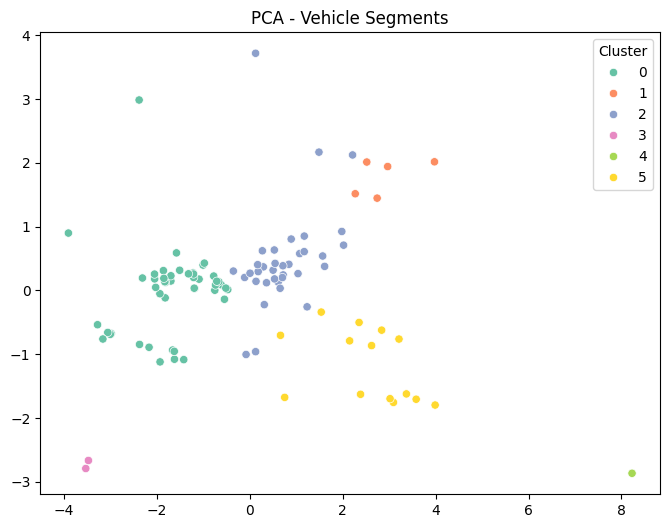

In [20]:
pca = PCA(n_components=2)
pca_vehicle = pca.fit_transform(scaled_vehicle)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_vehicle[:,0], y=pca_vehicle[:,1], hue=vehicle_df['Cluster'], palette='Set2')
plt.title('PCA - Vehicle Segments')
plt.show()


In [21]:
from sklearn.cluster import KMeans

# Define number of clusters after observing elbow plot
k_demo = 3

# Apply KMeans
kmeans_demo = KMeans(n_clusters=k_demo, random_state=42)
demographic_clean['Cluster'] = kmeans_demo.fit_predict(scaled_demo)

# View Cluster Assignments
print(demographic_clean[['Age', 'Total Salary', 'Price', 'Cluster']].head())

# Analyze clusters
print("\n--- Demographic Clustering ---")
print(demographic_clean.groupby('Cluster').mean())


   Age  Total Salary    Price  Cluster
0   27        800000   800000        0
1   35       2000000  1000000        2
2   45       1800000  1200000        2
3   41       2200000  1200000        1
4   31       2600000  1600000        2

--- Demographic Clustering ---
               Age  Profession  Marrital Status  Education  No of Dependents  \
Cluster                                                                        
0        29.458333    0.625000            0.625   0.583333          0.166667   
1        38.937500    0.625000            0.000   0.562500          2.812500   
2        37.740741    0.703704            0.000   0.555556          2.851852   

         Personal loan  Total Salary         Price  
Cluster                                             
0             0.208333  1.491667e+06  1.071250e+06  
1             0.000000  2.668750e+06  1.347917e+06  
2             1.000000  2.255556e+06  1.029630e+06  


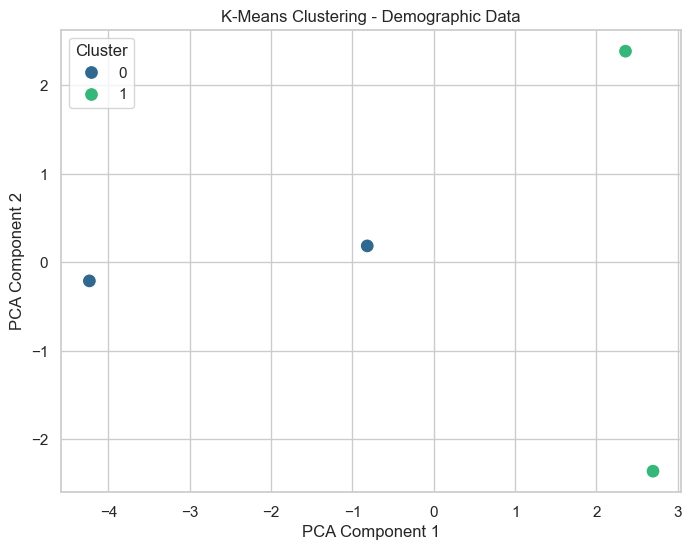

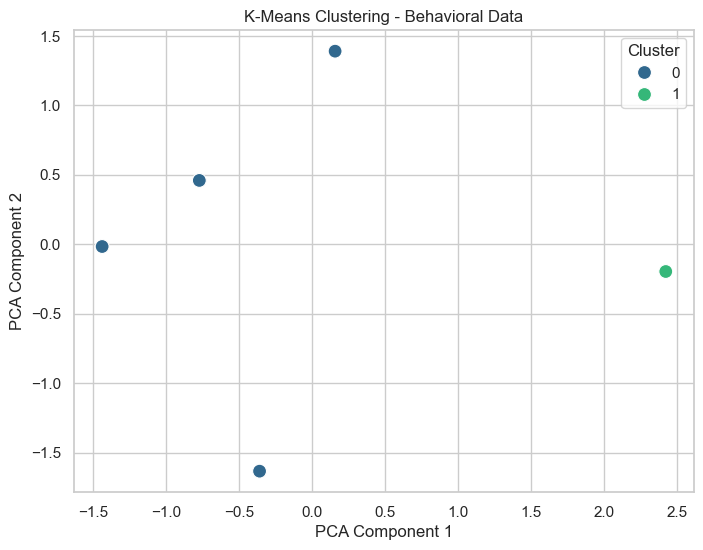

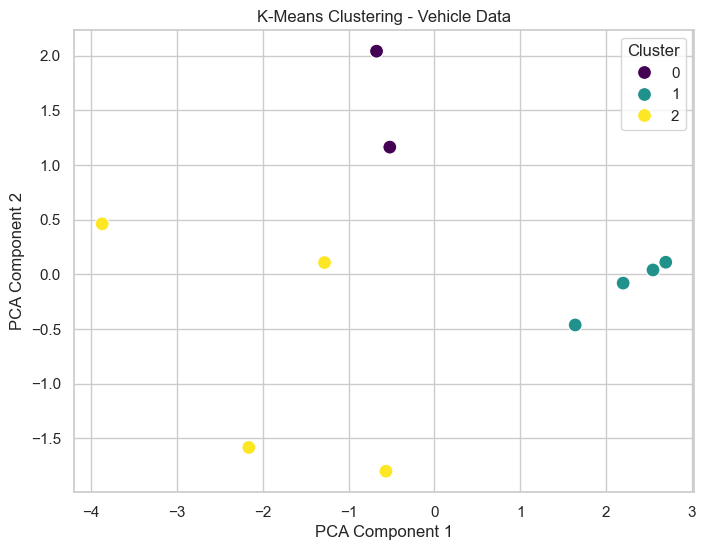

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_kmeans_clusters(scaled_data, kmeans_model, title):
    # Reduce to 2D using PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced_data[:, 0], 
        y=reduced_data[:, 1], 
        hue=kmeans_model.labels_, 
        palette='viridis', 
        s=100
    )
    plt.title(f'K-Means Clustering - {title}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# Run for all three datasets
plot_kmeans_clusters(scaled_demo, kmeans_demo, "Demographic Data")
plot_kmeans_clusters(scaled_behavioral, kmeans_behavioral, "Behavioral Data")
plot_kmeans_clusters(scaled_vehicle, kmeans_vehicle, "Vehicle Data")
